<a href="https://colab.research.google.com/github/davidklhui/data-analysis/blob/main/Tensorflow_(2)_LSTM_for_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This network demonstrate the use of LSTM (Long Short-Term Memory) to perform time series analysis.

# Introduction

In data science topics, RNN (recurrent neural networks) is a type of neural networks, that is a machine learning algorithm that aim at analyzing sequential data like time series analysis and netural language processing (NLP).

LSTM is an improvement of traditional RNNs, where major benefits are:
1. help avoid some problem when using traditional RNN (like the so-called vanishing gradients)  
2. RNN may sometime hard to capture the long-term dependencies of the data; while LSTM are more effective in remembering the long-term dependencies.

This project will perform an another approach to analyze the room temperature dataset, and we will then go throught the pros and cons between using LSTM and classic statistical time series analysis using ARIMA.

# RNN and LSTM

RNN is a type of neural networks, that for each neuron $y_n$, it takes input $y_{n-1}$, weight, and bias





# Procedures

1. Exploratory data analysis (EDA)
2. Data engineering (transformation, and train-test split)
3. Modeling (the LSTM model)
4. compare models with different hyperparameters
5. Model evaluation
6. Prediction

# Prerequisites



## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

Because training a LSTM model is computational intensive, to boost the training speed, we will use GPU (but on single GPU).

For the use TPU, see the [official guide](https://www.tensorflow.org/guide/tpu)

In [2]:
print("Num GPUs available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs available: 1


## Data Source

Like the ARIMA time series analysis project, we will also use the same dataset from Kaggle:
[Time Series Room Temperature Data](https://www.kaggle.com/datasets/vitthalmadane/ts-temp-1)

In [3]:
raw_data = pd.read_csv("./drive/MyDrive/datasource/MLTempDataset.csv")

In [4]:
raw_data.shape

(6676, 4)

In [5]:
raw_data.head()

,Unnamed: 0,Datetime1,DAYTON_MW,Datetime
0,0,0,20.867,2022-01-04 00:00:00
1,1,1,21.000,2022-01-04 01:00:00
2,2,2,20.867,2022-01-04 02:00:00
3,3,3,20.650,2022-01-04 03:00:00
4,4,4,20.400,2022-01-04 04:00:00


In [6]:
data = raw_data[['Datetime', 'DAYTON_MW']]
data['Datetime'] = pd.to_datetime(data['Datetime'])

data = data.set_index(data['Datetime'])
data = data.rename(columns={'DAYTON_MW': 'temperature'})

data.drop('Datetime', axis=1, inplace=True)

<ipython-input-6-dcd4b8d5058d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Datetime'] = pd.to_datetime(data['Datetime'])


# Exploratory Data Analysis

## Simple data description

In [7]:
# info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6676 entries, 2022-01-04 00:00:00 to 2022-10-09 03:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  6676 non-null   float64
dtypes: float64(1)
memory usage: 104.3 KB


In [8]:
data.min(), data.max()

(temperature    5.35
 dtype: float64,
 temperature    36.5
 dtype: float64)

here there are 6676 rows, starting from 2022-01-04 00:00:00 to 2022-10-09 03:00:00

And among these, the minimum temperature is 5.35, while the maximum is 36.5


## Time series plot

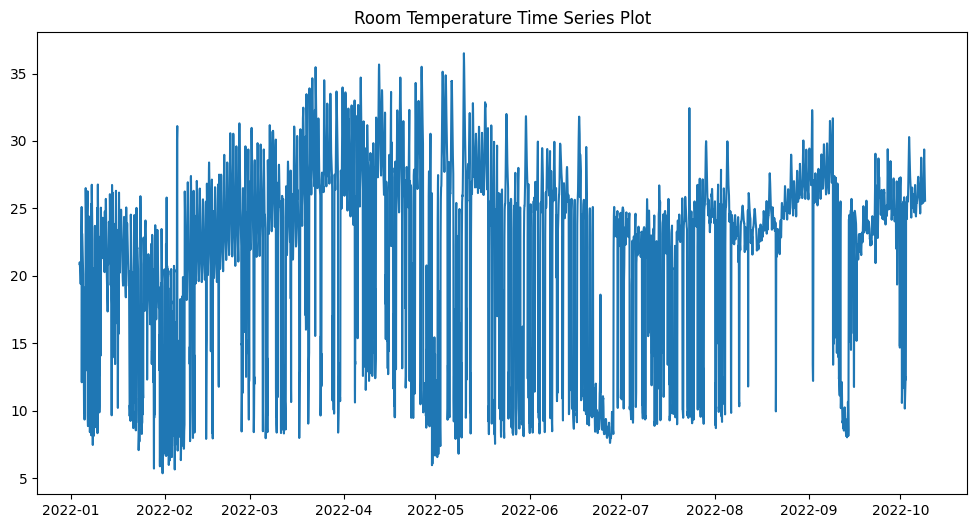

In [9]:
plt.figure(figsize=(12,6))
plt.plot(data['temperature'])
plt.title('Room Temperature Time Series Plot')
plt.show()

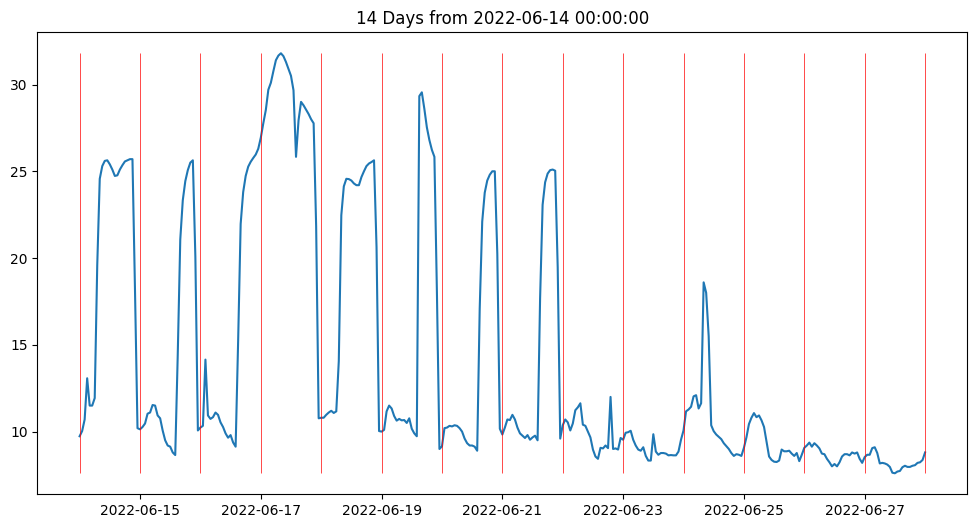

In [10]:
# plot a random N days
duration_days = 14
at_day = np.random.choice(np.arange(int(data.shape[0]/24)-duration_days), 1)[0]

plot_data = data.iloc[at_day*24:((at_day+duration_days)*24 + 1),0]
plt.figure(figsize=(12,6))
plt.plot(plot_data)

plt.title("%s Days from %s" % (duration_days, plot_data.index[0]))

vertical_lines = pd.date_range(start=plot_data.index[0], end=plot_data.index[-1], inclusive='both', freq="d").map(lambda x: x.strftime('%Y-%m-%d'))
plt.vlines(vertical_lines, ymin=plot_data.min(), ymax=plot_data.max(),
            color='red', linestyles='-', linewidth=.5)


as we discovered before, the room temperature appears to have a daily pattern

# Data Engineering

This section will perform:
1. train-test split
2. transformation (using min-max scaler)



## Splitting the data

Because time series data has its correlated structure, we should not perform train-test split with shuffling.

In this train test split process, we can simple define the test size. Then using simple numpy array index slicing to reserve the size for testing. The rest are training data

By refering to the ARIMA project, we have defined the cutoff date to be 2022-10-05 00:00:00, in this case the test size will be 4*24+4 = 100

In [11]:
# reserve the data on and after 5/10/2022 for testing purpose
cutoff_date = pd.to_datetime('2022-10-05 00:00:00')
train_data = data[data.index < cutoff_date]

test_data = data[data.index >= cutoff_date]

# for the training data, reserve 15% data for validation
# without using sklearn train-test split because we did not yet define X and y
train_size = int(train_data.shape[0] *  0.85)
validation_size = train_data.shape[0] - train_size

validation_data = train_data[(- validation_size):]
train_data = train_data[:(- validation_size)]


In [12]:
train_size = train_data.shape[0]
validation_size = validation_data.shape[0]
test_size = test_data.shape[0]

In [13]:
# training dataset raw data
print("training size: ", train_size)

train_data.head(), train_data.tail()

training size:  5589


(                     temperature
 Datetime                        
 2022-01-04 00:00:00       20.867
 2022-01-04 01:00:00       21.000
 2022-01-04 02:00:00       20.867
 2022-01-04 03:00:00       20.650
 2022-01-04 04:00:00       20.400,
                      temperature
 Datetime                        
 2022-08-24 16:00:00       24.700
 2022-08-24 17:00:00       24.333
 2022-08-24 18:00:00       24.167
 2022-08-24 19:00:00       24.417
 2022-08-24 20:00:00       24.740)

In [14]:
# validation dataset raw data
print("validation size: ", validation_size)

validation_data.head(), validation_data.tail()

validation size:  987


(                     temperature
 Datetime                        
 2022-08-24 21:00:00       25.233
 2022-08-24 22:00:00       25.350
 2022-08-24 23:00:00       25.700
 2022-08-25 00:00:00       25.943
 2022-08-25 01:00:00       26.317,
                      temperature
 Datetime                        
 2022-10-04 19:00:00       26.233
 2022-10-04 20:00:00       26.467
 2022-10-04 21:00:00       26.540
 2022-10-04 22:00:00       26.300
 2022-10-04 23:00:00       25.900)

In [15]:
# testing dataset raw data
print("validation size: ", test_size)

test_data.head(), test_data.tail()

validation size:  100


(                     temperature
 Datetime                        
 2022-10-05 00:00:00       26.075
 2022-10-05 01:00:00       25.750
 2022-10-05 02:00:00       25.267
 2022-10-05 03:00:00       25.017
 2022-10-05 04:00:00       25.250,
                      temperature
 Datetime                        
 2022-10-08 23:00:00       27.350
 2022-10-09 00:00:00       26.800
 2022-10-09 01:00:00       26.450
 2022-10-09 02:00:00       25.900
 2022-10-09 03:00:00       25.567)

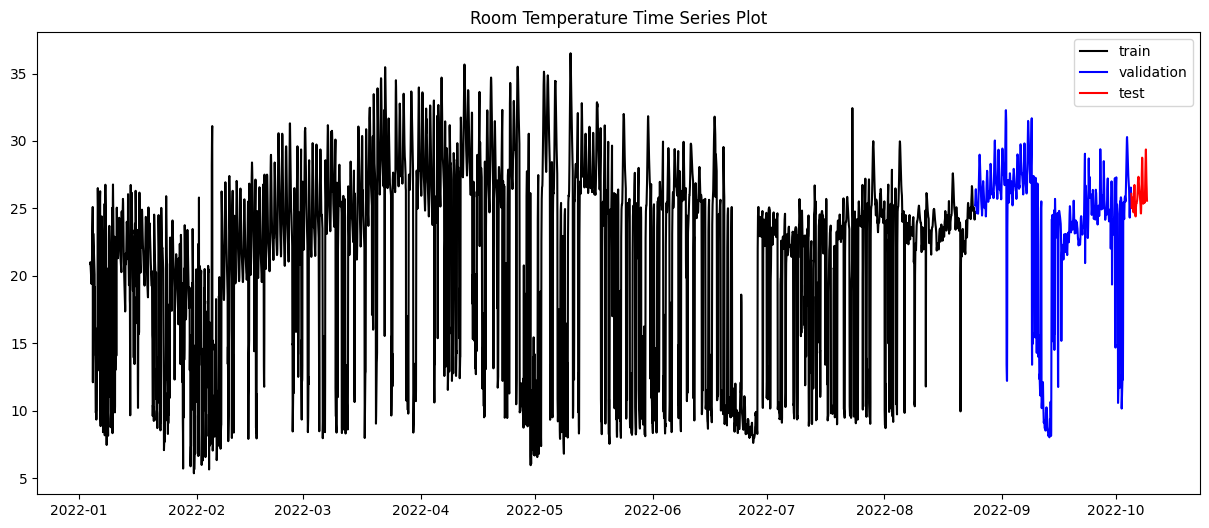

In [16]:
plt.figure(figsize=(15,6))

plt.title('Room Temperature Time Series Plot')

plt.plot(train_data, color='black', label="train")
plt.plot(validation_data, color='blue', label="validation")
plt.plot(test_data, color="red", label="test")

plt.legend()

plt.show()

## Data Transformation

This will perform 2 operations:
1. transform each dataset into features (X) and outcome (y)
2. perform min-max scaling

First we need to transform the dataset into X and y. X (features) is the data input, and y be the output.

For time series analysis, we define a window size, that use the data within the window for the next data.

For example, suppose there is a sequence [1,2,3,4,5,6,7,8,9] with window size = 4, then we use [1,2,3] to predict [4], [2,3,4] to predict [5], and so on ...

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train_data)
scaled_validation = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)


In [18]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array


# scaled_data: the scaled version of time series array; raw_data: the original time series array
def timeseries_dataset(scaled_data, raw_data, window_size):

  dataset = timeseries_dataset_from_array(
    scaled_data[:-1], np.roll(raw_data, -window_size)[:-1], window_size, batch_size=1)

  return dataset


In [44]:
window_size = 6

# ts_ds - time series dataset
ts_ds_train = timeseries_dataset(scaled_train, train_data['temperature'], window_size)
ts_ds_validation = timeseries_dataset(scaled_validation, validation_data['temperature'], window_size)
ts_ds_test = timeseries_dataset(scaled_test, test_data['temperature'], window_size)



# Model building & Evaluation

We used basic LSTM model to perform time series modelling. We will build a basic model first, then try to adjust the hyperparameters to find a best model with minimal validation data MSE

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

## Model1

1. LSTM(50) -> Dense(1)
2. window size = 6

In [46]:
# defining the LSTM model: a single LSTM hidden layer with 50 neurons

model = Sequential()
model.add(LSTM(50, input_shape=(window_size, 1), activation='tanh'))
model.add(Dense(1)) # for modeling univariate time series, there is a single output

#model.compile(optimizer='Adam(lr=.005)', loss='mse')
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                10400     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# define early stopping mechanism
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [48]:

# large epochs is fine as we defined early stopping
# because LSTM's model complexity it is computational intensive. The training time will be very long, so using GPU/TPU can boost the training speed
with tf.device('/gpu:0'):
  model.fit(ts_ds_train, epochs=100, validation_data=ts_ds_validation, callbacks=[early_stop])


Epoch 1/100
5583/5583 [==============================] - 22s 4ms/step - loss: 41.8768 - val_loss: 19.2443
Epoch 2/100
5583/5583 [==============================] - 20s 4ms/step - loss: 19.7232 - val_loss: 6.1705
Epoch 3/100
5583/5583 [==============================] - 20s 4ms/step - loss: 10.6516 - val_loss: 4.3891
Epoch 4/100
5583/5583 [==============================] - 20s 4ms/step - loss: 9.0286 - val_loss: 3.9030
Epoch 5/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.6913 - val_loss: 3.7833
Epoch 6/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.5602 - val_loss: 3.7494
Epoch 7/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.4489 - val_loss: 3.7163
Epoch 8/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.3651 - val_loss: 3.7084
Epoch 9/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.2938 - val_loss: 3.6839
Epoch 10/100
5583/5583 [==============================] - 20

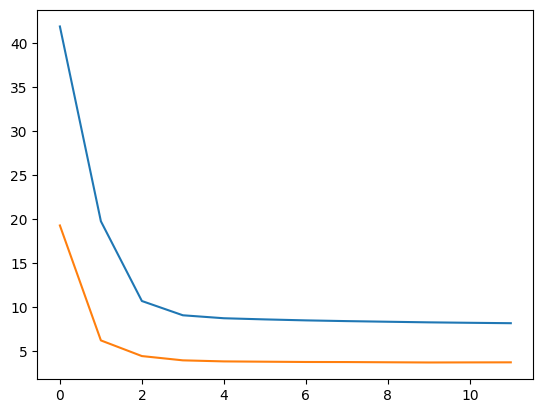

In [49]:
losses = pd.DataFrame(model.history.history)
plt.plot(losses)

In [50]:
validation_predictions = pd.DataFrame(columns=['true', 'predict'])

for feature, value in ts_ds_validation:
  prediction = model.predict(feature)

  validation_predictions.loc[validation_predictions.shape[0]] = [value.numpy()[0], prediction[0][0]]


1/1 [==============================] - 0s 17ms/step


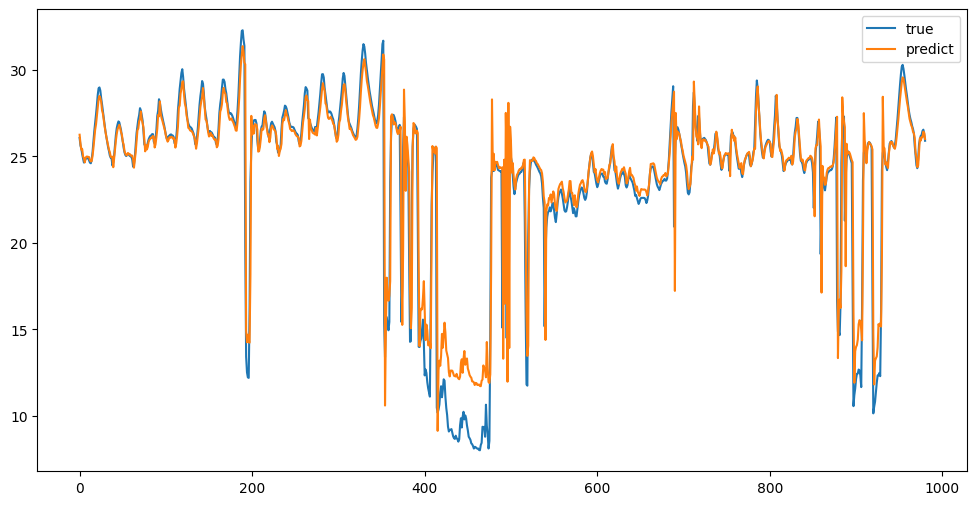

In [51]:
validation_predictions.plot(figsize=(12,6))
plt.show()

In [52]:
# see the performance on validation dataset
from sklearn.metrics import mean_squared_error

mse1 = mean_squared_error(validation_predictions['true'], validation_predictions['predict'])

mse1

3.6771865173447145

Then we will try different models to see which one has the lowest validation MSE. Once we conclude a "best" model, then we will evaluate the MSE for test dataset

Before trying more models, define some handy function for simplcity

In [55]:
# to prevent code replication, define a function by simply supplying the model, all remaining codes are the same

def model_fit(model, window_size):

  # ts_ds - time series dataset
  train = timeseries_dataset(scaled_train, train_data['temperature'], window_size)
  validation = timeseries_dataset(scaled_validation, validation_data['temperature'], window_size)

  # use optimizer 'adam', with loss function = mse
  model.compile(optimizer='adam', loss='mse')

  with tf.device('/gpu:0'):
    model.fit(train, epochs=100, validation_data=validation, callbacks=[early_stop])

  print('model summary: ', model.summary())
  history = pd.DataFrame(model.history.history)
  history.plot()
  plt.show()

  validation_predictions = pd.DataFrame(columns=['true', 'predict'])

  for feature, value in validation:
    prediction = model.predict(feature)
    validation_predictions.loc[validation_predictions.shape[0]] = [value.numpy()[0], prediction[0][0]]

  validation_predictions.plot(figsize=(12,6))
  plt.show()

  # validation MSE
  mse = mean_squared_error(validation_predictions['true'], validation_predictions['predict'])
  print('mse: ', mse)

  return {'model': model, 'history': history, 'prediction': validation_predictions['predict'], 'mse': mse}

## Model2: using more LSTM units under Model1

1. LSTM(100) -> Dense(1)
2. window size = 6

In [56]:
model2 = Sequential()
model2.add(LSTM(100, input_shape=(window_size, 1), activation='tanh'))
model2.add(Dense(1))


Epoch 1/100
5583/5583 [==============================] - 22s 4ms/step - loss: 43.2826 - val_loss: 25.6917
Epoch 2/100
5583/5583 [==============================] - 20s 4ms/step - loss: 36.0875 - val_loss: 18.9925
Epoch 3/100
5583/5583 [==============================] - 20s 4ms/step - loss: 23.4395 - val_loss: 8.6965
Epoch 4/100
5583/5583 [==============================] - 20s 4ms/step - loss: 13.3048 - val_loss: 5.2145
Epoch 5/100
5583/5583 [==============================] - 20s 4ms/step - loss: 10.5374 - val_loss: 4.3532
Epoch 6/100
5583/5583 [==============================] - 20s 4ms/step - loss: 9.4429 - val_loss: 4.0447
Epoch 7/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.9374 - val_loss: 3.9336
Epoch 8/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.6943 - val_loss: 3.8933
Epoch 9/100
5583/5583 [==============================] - 20s 4ms/step - loss: 8.5548 - val_loss: 3.8573
Epoch 10/100
5583/5583 [==============================] -

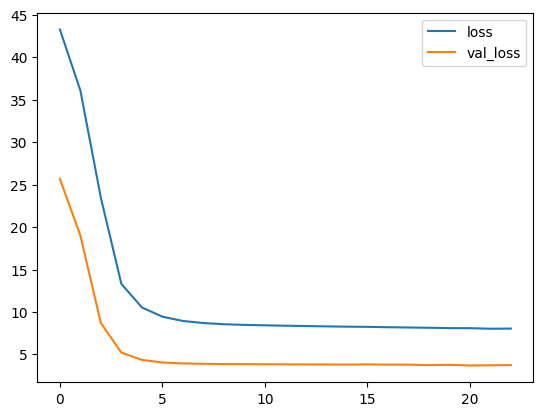

1/1 [==============================] - 0s 18ms/step


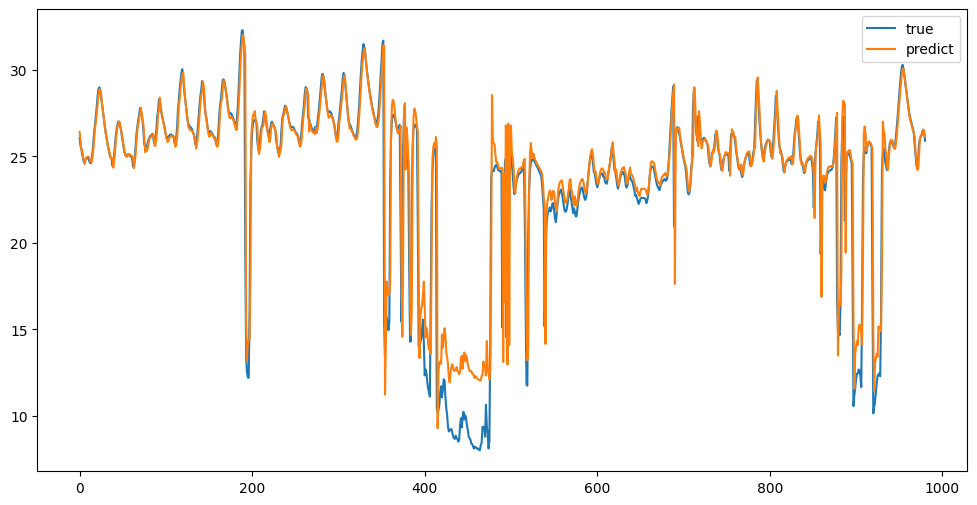

mse:  3.736244383250485


In [57]:
fit2 = model_fit(model2, window_size=6)

In [58]:
mse2 = fit2['mse']

mse1, mse2

(3.6771865173447145, 3.736244383250485)

The validation MSE increases slighly, so Model1 appears to be better than Model2

## Model3: less LSTM units under Model1

1. LSTM(25) -> Dense(1)
2. window size = 6

Epoch 1/100
5583/5583 [==============================] - 21s 4ms/step - loss: 42.2624 - val_loss: 14.1019
Epoch 2/100
5583/5583 [==============================] - 20s 4ms/step - loss: 15.5683 - val_loss: 5.6303
Epoch 3/100
5583/5583 [==============================] - 19s 3ms/step - loss: 9.5256 - val_loss: 4.0928
Epoch 4/100
5583/5583 [==============================] - 20s 3ms/step - loss: 8.8289 - val_loss: 3.9379
Epoch 5/100
5583/5583 [==============================] - 19s 3ms/step - loss: 8.6427 - val_loss: 3.8906
Epoch 6/100
5583/5583 [==============================] - 19s 3ms/step - loss: 8.5260 - val_loss: 3.8614
Epoch 7/100
5583/5583 [==============================] - 19s 3ms/step - loss: 8.4447 - val_loss: 3.8418
Epoch 8/100
5583/5583 [==============================] - 19s 3ms/step - loss: 8.3824 - val_loss: 3.8296
Epoch 9/100
5583/5583 [==============================] - 19s 3ms/step - loss: 8.3278 - val_loss: 3.8265
Epoch 10/100
5583/5583 [==============================] - 20s

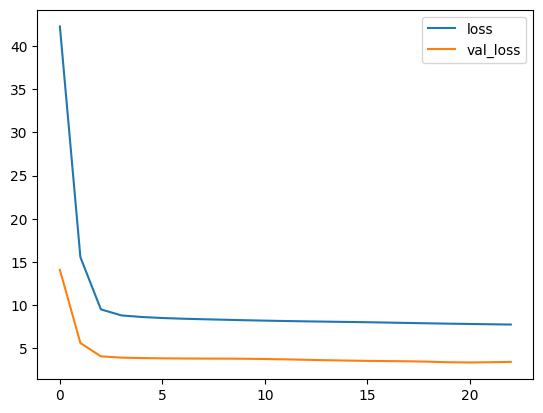

1/1 [==============================] - 0s 18ms/step


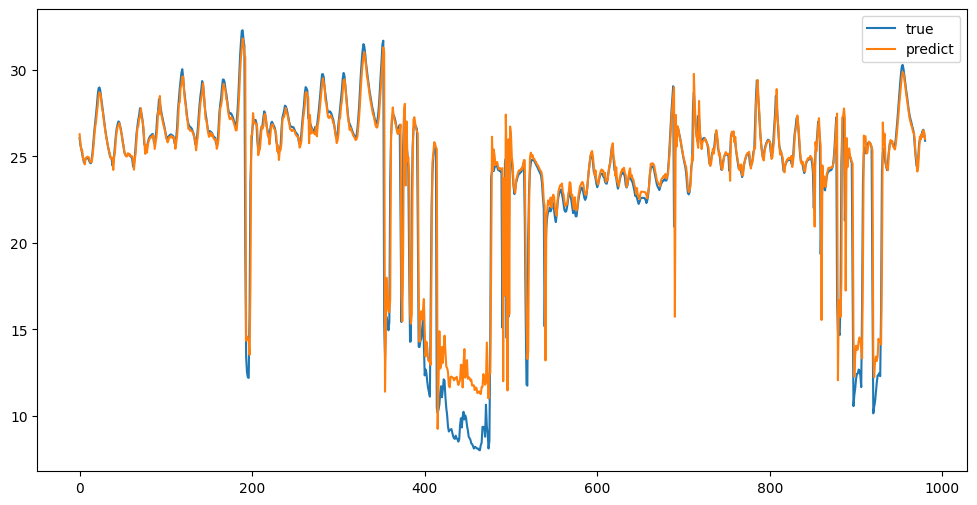

mse:  3.447186492260306


In [59]:
model3 = Sequential()
model3.add(LSTM(25, input_shape=(window_size, 1), activation='tanh'))
model3.add(Dense(1))

fit3 = model_fit(model3, window_size=6)


In [60]:
mse3 = fit3['mse']
mse1, mse3

(3.6771865173447145, 3.447186492260306)

The validation MSE decreases, so Model3 appears to be better than Model1

## Model4: extra LSTM layer under Model3

1. LSTM(25) -> LSTM(25) -> Dense(1)
2. window size = 6

Epoch 1/100
5583/5583 [==============================] - 30s 5ms/step - loss: 36.7345 - val_loss: 6.0414
Epoch 2/100
5583/5583 [==============================] - 27s 5ms/step - loss: 9.5068 - val_loss: 3.8998
Epoch 3/100
5583/5583 [==============================] - 28s 5ms/step - loss: 8.6777 - val_loss: 3.8631
Epoch 4/100
5583/5583 [==============================] - 27s 5ms/step - loss: 8.5473 - val_loss: 3.8879
Epoch 5/100
5583/5583 [==============================] - 27s 5ms/step - loss: 8.4054 - val_loss: 3.9222
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 6, 25)             2700      
                                                                 
 lstm_12 (LSTM)              (None, 25)                5100      
                                                                 
 dense_10 (Dense)            (None, 1)                 26   

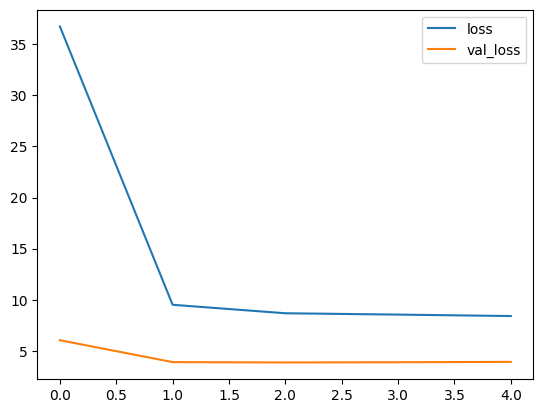

1/1 [==============================] - 0s 19ms/step


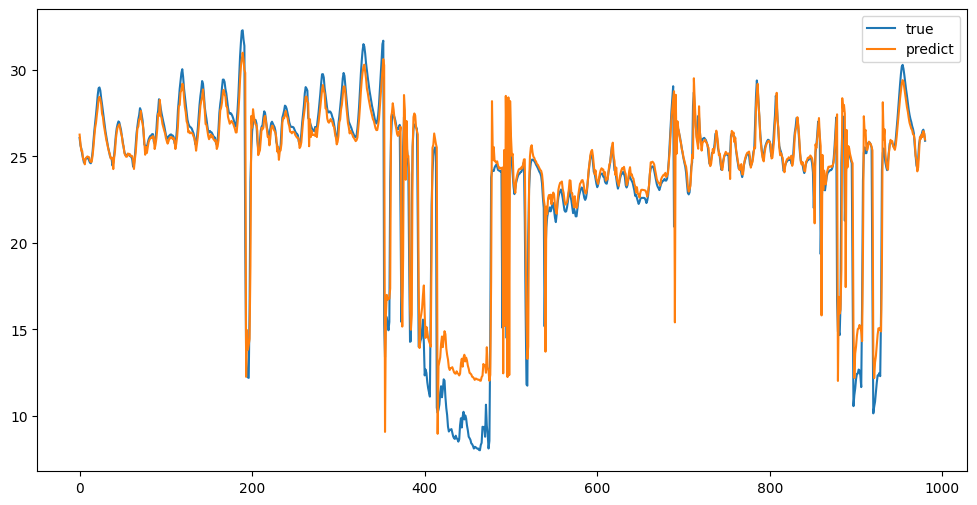

mse:  3.9221850645570044


In [61]:
model4 = Sequential()
model4.add(LSTM(25, input_shape=(window_size, 1), activation='tanh', return_sequences=True))
model4.add(LSTM(25, activation="tanh"))
model4.add(Dense(1))

fit4 = model_fit(model4, window_size=6)


In [62]:
mse4 = fit4['mse']
mse3, mse4

(3.447186492260306, 3.9221850645570044)

increases in MSE, so Model4 is worse than Model3

## Model5: extra Dense layer under Model3

1. LSTM(25) -> Dense(100) -> Dense(1)
2. window size = 6

Epoch 1/100
5583/5583 [==============================] - 27s 4ms/step - loss: 36.5206 - val_loss: 12.9772
Epoch 2/100
5583/5583 [==============================] - 24s 4ms/step - loss: 27.7122 - val_loss: 13.0631
Epoch 3/100
5583/5583 [==============================] - 25s 4ms/step - loss: 27.0356 - val_loss: 13.1391
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 6, 25)             2700      
                                                                 
 dense_11 (Dense)            (None, 6, 100)            2600      
                                                                 
 dense_12 (Dense)            (None, 6, 1)              101       
                                                                 
Total params: 5401 (21.10 KB)
Trainable params: 5401 (21.10 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

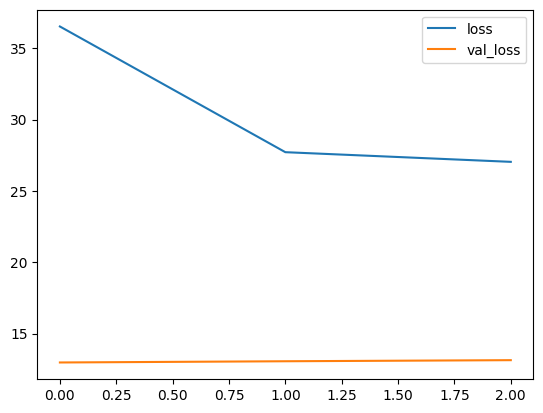

1/1 [==============================] - 0s 21ms/step


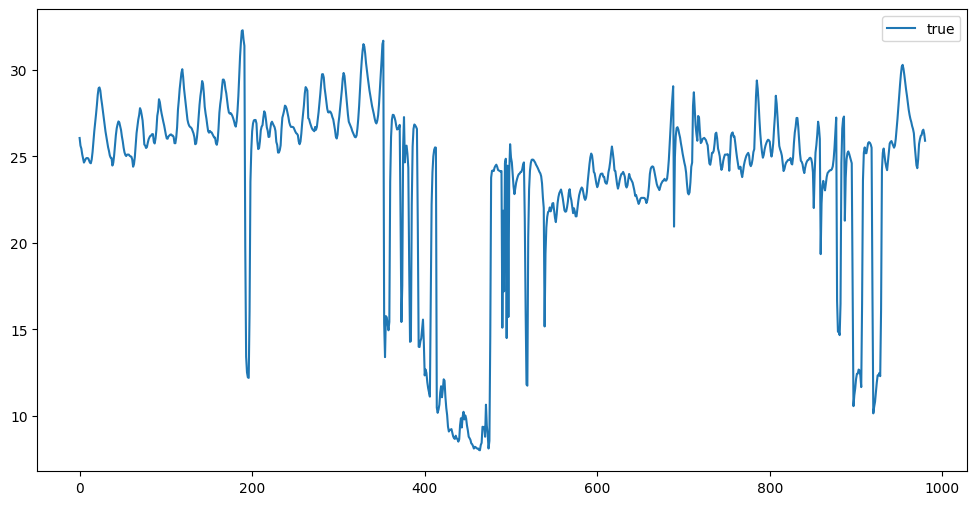

mse:  17.939570035324788


In [64]:
model5 = Sequential()
model5.add(LSTM(25, input_shape=(window_size, 1), activation='tanh', return_sequences=True))
model5.add(Dense(100))
model5.add(Dense(1))

fit5 = model_fit(model5, window_size=6)

In [65]:
mse5 = fit5['mse']
mse3, mse5

(3.447186492260306, 17.939570035324788)

Worst model. We keep trying to improve from Model3

## Model6: change window size to 12 under Model3

1. LSTM(25) -> Dense(1)
2. window size = 12

Epoch 1/100
5577/5577 [==============================] - 22s 4ms/step - loss: 50.2426 - val_loss: 23.2061
Epoch 2/100
5577/5577 [==============================] - 21s 4ms/step - loss: 15.4668 - val_loss: 5.2354
Epoch 3/100
5577/5577 [==============================] - 21s 4ms/step - loss: 9.4107 - val_loss: 3.9236
Epoch 4/100
5577/5577 [==============================] - 21s 4ms/step - loss: 8.6980 - val_loss: 3.6465
Epoch 5/100
5577/5577 [==============================] - 20s 4ms/step - loss: 8.5484 - val_loss: 3.5689
Epoch 6/100
5577/5577 [==============================] - 21s 4ms/step - loss: 8.4552 - val_loss: 3.5388
Epoch 7/100
5577/5577 [==============================] - 21s 4ms/step - loss: 8.3864 - val_loss: 3.5159
Epoch 8/100
5577/5577 [==============================] - 21s 4ms/step - loss: 8.3426 - val_loss: 3.4953
Epoch 9/100
5577/5577 [==============================] - 21s 4ms/step - loss: 8.2870 - val_loss: 3.4886
Epoch 10/100
5577/5577 [==============================] - 21s

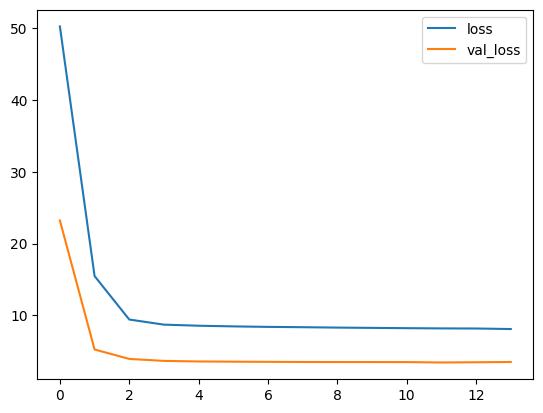

1/1 [==============================] - 0s 25ms/step


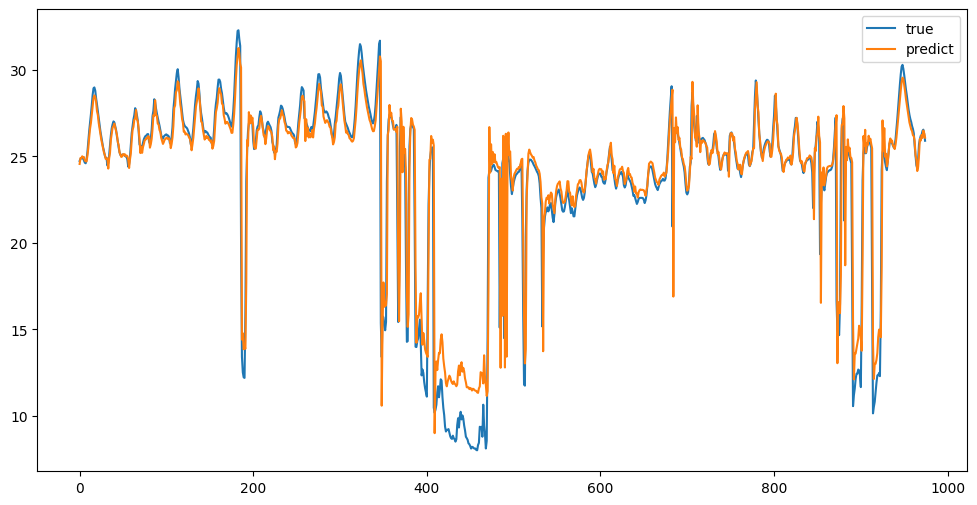

mse:  3.494515121878658


In [66]:
window_size = 12

model6 = Sequential()
model6.add(LSTM(25, input_shape=(window_size, 1), activation='tanh'))
model6.add(Dense(1))

fit6 = model_fit(model6, window_size=12)

In [67]:
mse6 = fit6['mse']
mse3, mse6

(3.447186492260306, 3.494515121878658)

Slighly increase, may be worth try higher window size = 24 (daily = 24 hours)

## Model7: change window size to 12 under Model3

1. LSTM(25) -> Dense(1)
2. window size = 24

Epoch 1/100
5565/5565 [==============================] - 24s 4ms/step - loss: 48.1314 - val_loss: 22.6068
Epoch 2/100
5565/5565 [==============================] - 22s 4ms/step - loss: 14.8895 - val_loss: 4.9309
Epoch 3/100
5565/5565 [==============================] - 22s 4ms/step - loss: 9.2556 - val_loss: 4.5752
Epoch 4/100
5565/5565 [==============================] - 22s 4ms/step - loss: 8.7890 - val_loss: 4.4817
Epoch 5/100
5565/5565 [==============================] - 22s 4ms/step - loss: 8.6530 - val_loss: 4.3754
Epoch 6/100
5565/5565 [==============================] - 22s 4ms/step - loss: 8.5304 - val_loss: 4.3109
Epoch 7/100
5565/5565 [==============================] - 22s 4ms/step - loss: 8.4313 - val_loss: 4.2880
Epoch 8/100
5565/5565 [==============================] - 22s 4ms/step - loss: 8.3741 - val_loss: 4.2181
Epoch 9/100
5565/5565 [==============================] - 22s 4ms/step - loss: 8.3049 - val_loss: 4.1128
Epoch 10/100
5565/5565 [==============================] - 22s

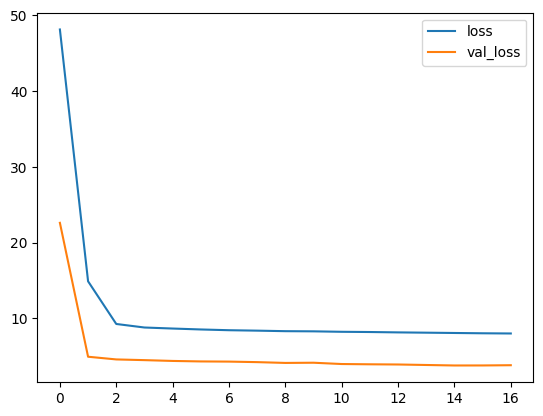

1/1 [==============================] - 0s 18ms/step


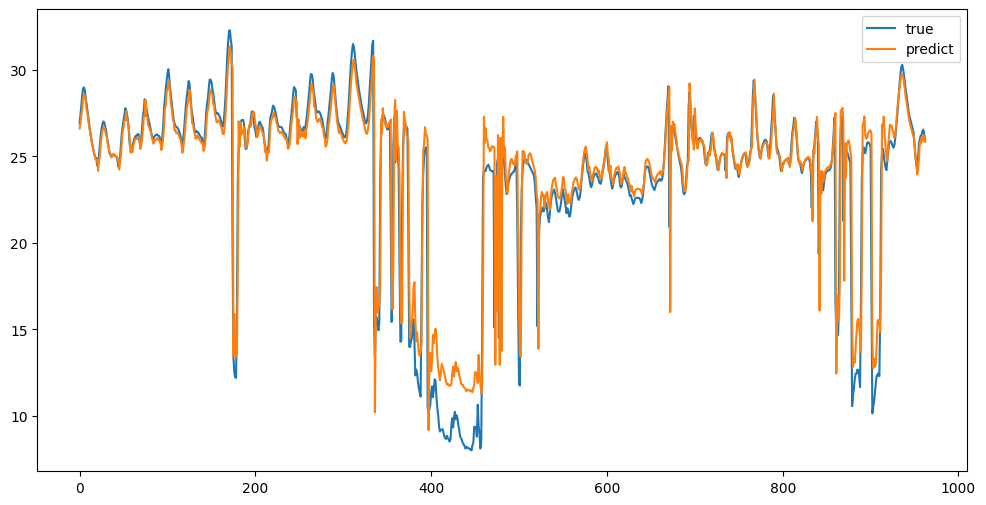

mse:  3.8113886717186607


In [68]:
window_size = 24

model7 = Sequential()
model7.add(LSTM(25, input_shape=(window_size, 1), activation='tanh'))
model7.add(Dense(1))

fit7 = model_fit(model7, window_size)

In [69]:
mse7 = fit7['mse']
mse3, mse7

(3.447186492260306, 3.8113886717186607)

Seemed Model3 gives the lowest validation MSE

In [71]:
# Model3
fit3['model'].summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 25)                2700      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2726 (10.65 KB)
Trainable params: 2726 (10.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Accuracy

This section will check the model accuracy

In [76]:
model = fit3['model']

window_size = 6

1/1 [==============================] - 0s 18ms/step


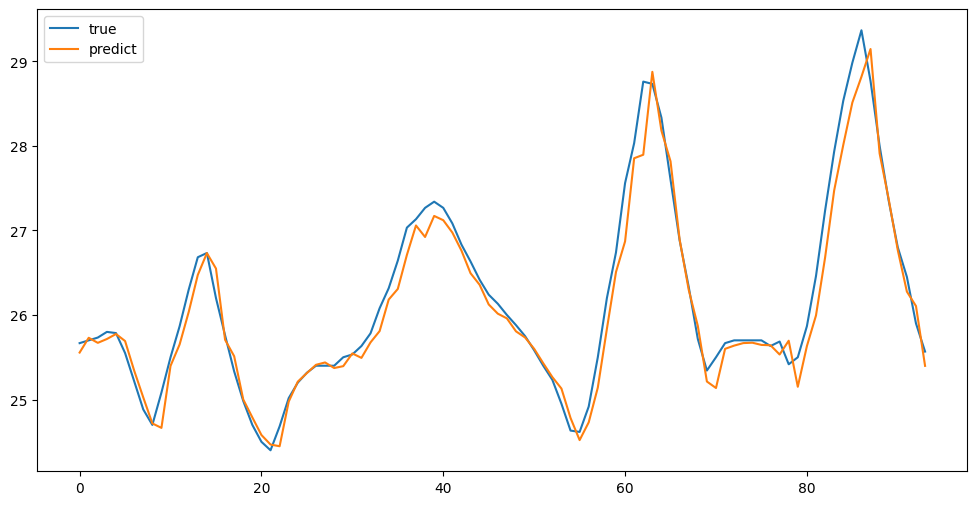

test mse:  0.056148263626764054


In [77]:
test_predictions = pd.DataFrame(columns=['true', 'predict'])


test = timeseries_dataset(scaled_test, test_data['temperature'], window_size)

for feature, value in test:
  prediction = model.predict(feature)
  test_predictions.loc[test_predictions.shape[0]] = [value.numpy()[0], prediction[0][0]]

test_predictions.plot(figsize=(12,6))
plt.show()

# validation MSE
test_mse = mean_squared_error(test_predictions['true'], test_predictions['predict'])
print('test mse: ', test_mse)

# Forecasting

We can use the whole dataset (including the validation and test dataset) to re-train the whole model. After that, we use the latest portion of the dataset as the initial batch to predict the next data point. Then discard the first element with appending the next data point as the next batch, and so on.

Then we can obtain a n-steps ahead forecasting

In [80]:
# re-train the whole dataset without validation using the model LSTM(25)->Dense(1) with window size=6

# defining the LSTM model: a single LSTM hidden layer with 50 neurons

model = Sequential()
model.add(LSTM(25, input_shape=(window_size, 1), activation='tanh'))
model.add(Dense(1)) # for modeling univariate time series, there is a single output

#model.compile(optimizer='Adam(lr=.005)', loss='mse')
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 25)                2700      
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 2726 (10.65 KB)
Trainable params: 2726 (10.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
data

,temperature
Datetime,
2022-01-04 00:00:00,20.867
2022-01-04 01:00:00,21.000
2022-01-04 02:00:00,20.867
2022-01-04 03:00:00,20.650
2022-01-04 04:00:00,20.400
...,...
2022-10-08 23:00:00,27.350
2022-10-09 00:00:00,26.800
2022-10-09 01:00:00,26.450


In [82]:
# scaled_full dataset

scaler = MinMaxScaler()
scaled_full = scaler.fit_transform(data)

# ts_ds - time series dataset
ts_ds_full = timeseries_dataset(scaled_full, data['temperature'], window_size)




Epoch 1/15
6670/6670 [==============================] - 24s 3ms/step - loss: 37.6877
Epoch 2/15
6670/6670 [==============================] - 21s 3ms/step - loss: 13.3399
Epoch 3/15
6670/6670 [==============================] - 21s 3ms/step - loss: 8.2112
Epoch 4/15
6670/6670 [==============================] - 21s 3ms/step - loss: 7.7917
Epoch 5/15
6670/6670 [==============================] - 21s 3ms/step - loss: 7.6640
Epoch 6/15
6670/6670 [==============================] - 21s 3ms/step - loss: 7.5694
Epoch 7/15
6670/6670 [==============================] - 21s 3ms/step - loss: 7.4958
Epoch 8/15
6670/6670 [==============================] - 22s 3ms/step - loss: 7.4360
Epoch 9/15
6670/6670 [==============================] - 22s 3ms/step - loss: 7.3827
Epoch 10/15
6670/6670 [==============================] - 21s 3ms/step - loss: 7.3405
Epoch 11/15
6670/6670 [==============================] - 22s 3ms/step - loss: 7.3056
Epoch 12/15
6670/6670 [==============================] - 21s 3ms/step - 

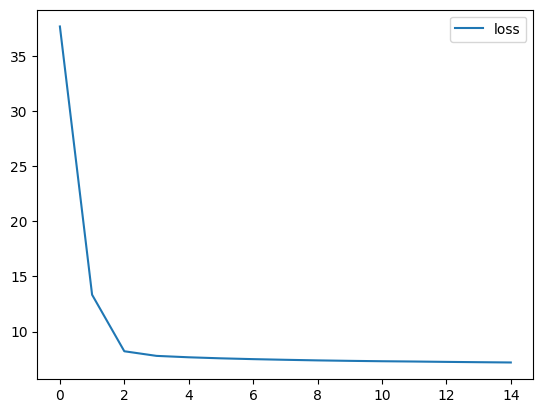

In [83]:
# use optimizer 'adam', with loss function = mse
model.compile(optimizer='adam', loss='mse')

# without validation, but with similar epoch as model3 (original training used 23, but the decrease in val_loss is small after 5. I think take 15~20 is reasonable)
with tf.device('/gpu:0'):
  model.fit(ts_ds_full, epochs=15)

print('model summary: ', model.summary())
history = pd.DataFrame(model.history.history)
history.plot()
plt.show()



In [120]:
# try predict the next 48 hours
n = 48

forecasting = []

initial_batch = list(ts_ds_full)[-1][0].numpy()
current_batch = initial_batch

for i in range(n):
  prediction = model.predict(current_batch)

  # append the i-step ahead forecasted value to the array
  forecasting.append(prediction[0,0])

  # update the current batch (and scaled the forecasted value)
  current_batch = np.append(current_batch[:,1:,:], [scaler.transform(prediction)], axis=1)



1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [121]:
forecasting_df = pd.DataFrame(forecasting)
forecasting_df.columns = ['forecast']

future_index = pd.date_range(start=data.index[-1], periods=(n+1), freq='h', inclusive='right')
forecasting_df = forecasting_df.set_index(future_index)

forecasting_df

,forecast
2022-10-09 04:00:00,25.772058
2022-10-09 05:00:00,25.874563
2022-10-09 06:00:00,26.084627
2022-10-09 07:00:00,26.315084
2022-10-09 08:00:00,26.526630
2022-10-09 09:00:00,26.702669
2022-10-09 10:00:00,26.834435
2022-10-09 11:00:00,26.921106
2022-10-09 12:00:00,26.968048
2022-10-09 13:00:00,26.984205


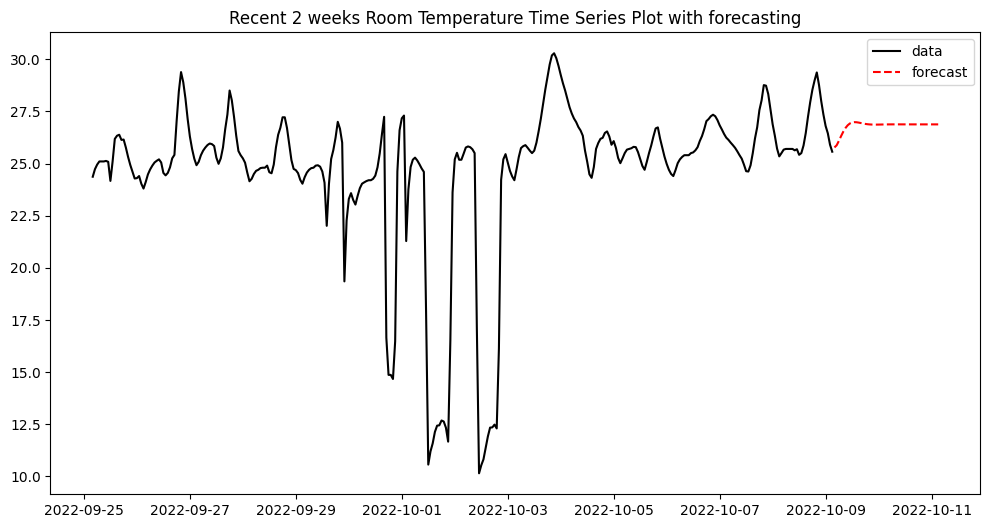

In [122]:
# see the final plot with forecasting
plt.figure(figsize=(12,6))
plt.plot(data[-14*24:], label='data', color='black')
plt.plot(forecasting_df, label='forecast', color='red', linestyle='--')
plt.title('Recent 2 weeks Room Temperature Time Series Plot with forecasting')

plt.legend()
plt.show()



From the plot, we can see that the forecasted value has initially raise, which seemed to mimic the seasonal behavior. But later on the model tend to forecast to a constant (as it flattened). Although looks unsatisactory, this may be a reasonable behavior because our original data has a pretty weak seasonal effect (not a highly repeating, clear seasonal pattern). So, somehow the model is able to predict the first few steps well, the subsequence forecasting maybe worse.

This is also a behavior of time series forecasting. This is because the forecasting uncertainty is accumulating, it is almost impossible to give reliable forecasting for a distant future.

# Comparison between LSTM and ARIMA

Recall from the previous project, we conclude that the seasonal ARIMA(1,1,2)(1,1,0)[24] has the lowest test mse, with mse = 0.872647, where the test mse of this LSTM project is 0.0561. We can see that using LSTM can have a better accuracy than that of using ARIMA in this case.

In general, because of the well-developed theory of ARIMA and the interpretability, we will always use ARIMA to model time series first unless some necessary assumptions failed (like the stationarity)

Advantages of using ARIMA over neural network:
1. it also gives many informative results like confidence interval for each forecasted value.
2. the model is easier to interpret, e.g. we can see the relationship between the current value with past value & errors
3. it is sometimes easier to choose "optimal" model for likelihood based models

Advantages of using neural network over ARIMA:
1. easy to use. Using neural network just need to perform many "standard tasks" like scaling, train-validation-test-split, trial-and-error to find better models; whereas to use ARIMA or another statistical models, it involves heavily on well-developed theory.
2. do not need to worry about data assumptions (more importantly, the stationarity assumption for ARIMA models)


# Conclusion

We have used another method to perform time series analysis than using ARIMA. From our findings, the final candidate model gives a better test_mse than using ARIMA model.